## Import relevant libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Recap

### Problem statement

1. The project, "Coordinate-based Optics-informed Convolution Neural Network (Cb-OI-CNN): A novel Physics-informed Neural Network (PINN) for recovering the reflectance of thin 2D samples" aims to solve the inverse problem of extracting the spatial reflectance map of a thin 2D collagen-rich tissue sample from conventional microscope images taken from a single viewpoint under "fixed" normal illumination without optical alignment procedures in a "reflection-based" mode
2. Our vision is a "self-supervised" CNN-based PINN platform that blends "Vanilla" and "Physics-based" (mimicking underlying processes and embedding crucial information) Layers for a unified approach

### Why CNNs?

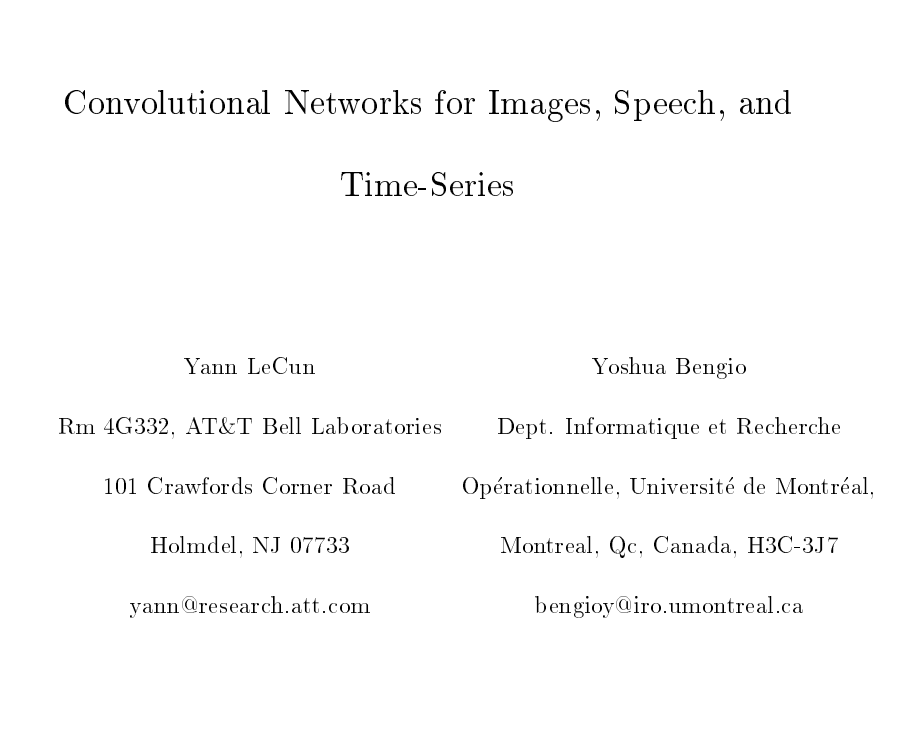

https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=e26cc4a1c717653f323715d751c8dea7461aa105

1. CNNs are a natural choice while working with data from images
2. The cornerstone work by Yann LeCun and Yoshua Bengio titled: "Convolutional Networks for Images, Speech, and Time-Series" highlight the advantage offered by a CNN over an ANN in capturing "locality" which is important for Images and Physical Fields
3. CNNs help incorporate coordinate-based representations, handle complex-valued fields and basis-function maps naturally (using channels)
4. Additionally, the "Physical Layer" in our Forward model representing the microscope lens is again, naturally captured using a CNN layer
5. Finally, for our problem, CNNs also provide a streamlined way of tracking various layers and ensure consistency in tensor shape across the board

### Overview

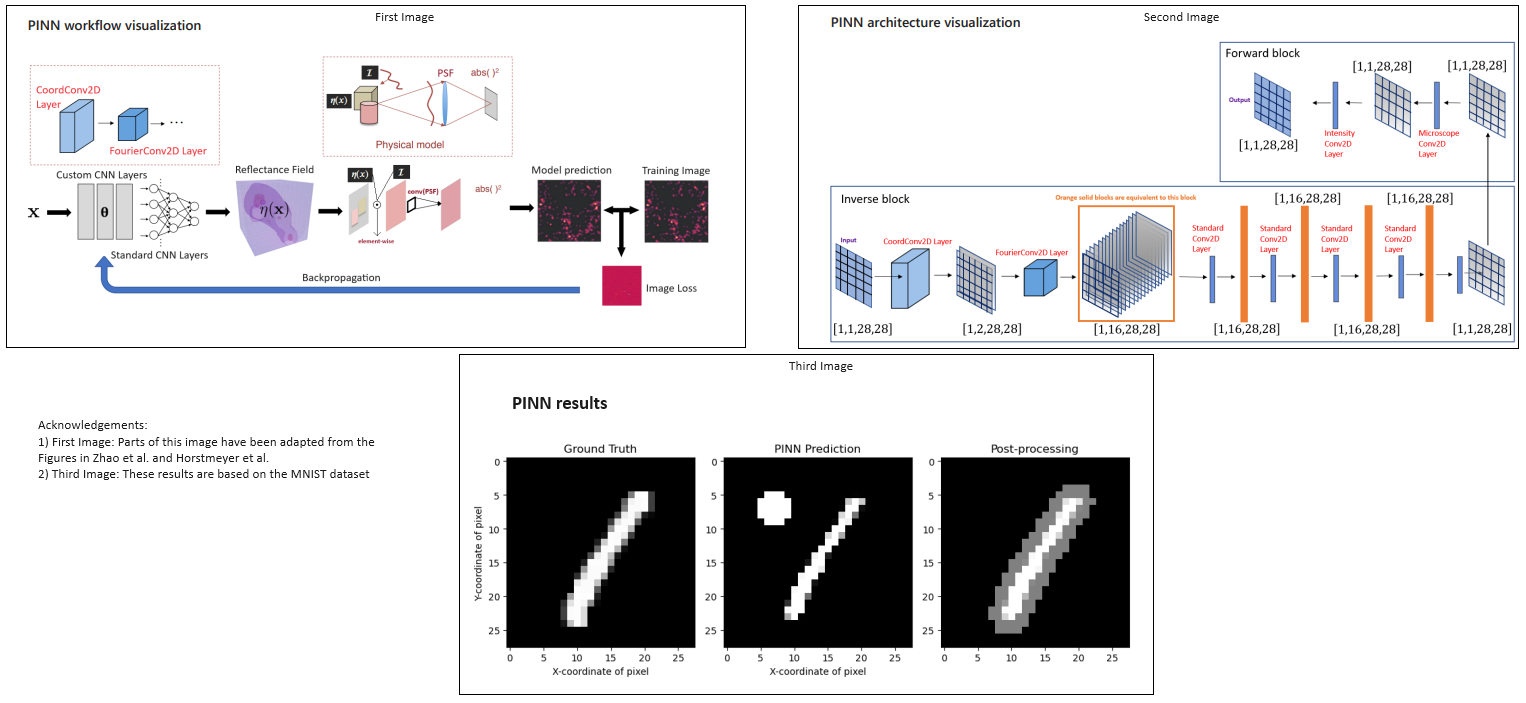

### Summary

1. Starting with a toy problem, we demonstrated success with the "simplest" synthetic sample (MNIST "one") but acknowledged the limitation of not incorporating scattering
2. The long term goal of this project is to apply this PINN platform to "real samples" of biological tissue of collagen-rich tissue
3. We know that the collagen sample we have scatters light as we get a "non-zero" signal in "cross-polarization"
4. Therefore, it makes sense as the next step to incorporate scattering into the forward model
5. In addition, our synthetic and biological samples have spatially varying optical properties. It is this "heterogeneity" that gives to scattering of light in tissue and has been discussed by Rogers et al. in their article titled: "Modeling Light Scattering in Tissue as Continuous Random Media Using a Versatile Refractive Index Correlation Function"

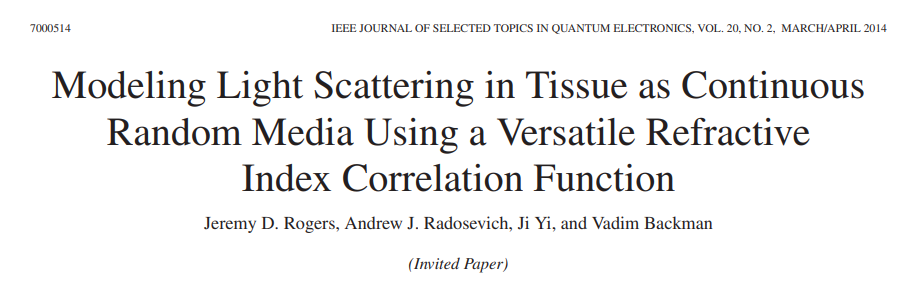

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4289622/

## MNIST motivation

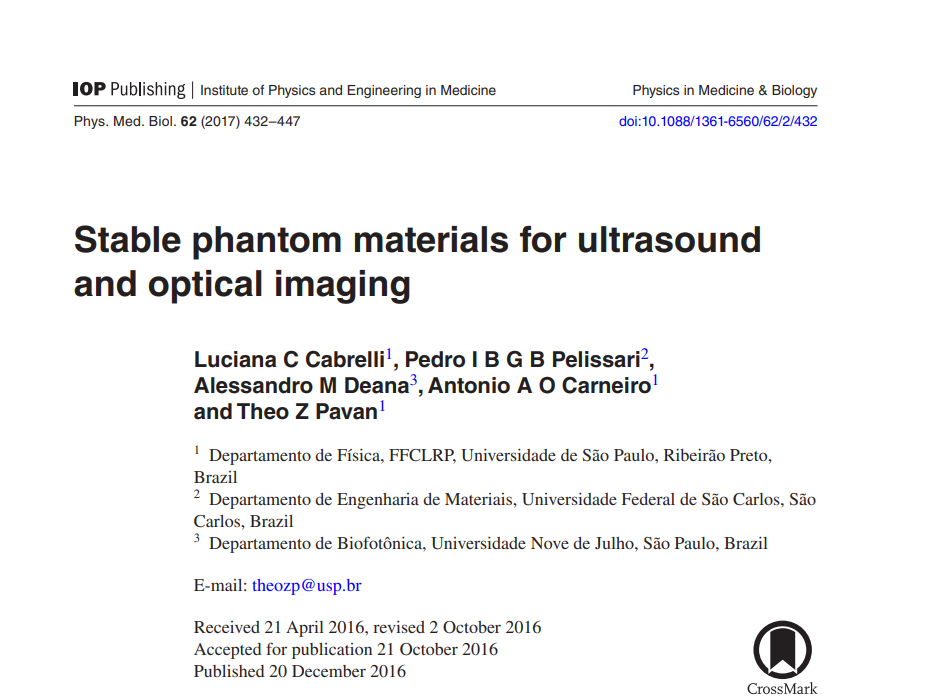

https://iopscience.iop.org/article/10.1088/1361-6560/62/2/432/meta

1. Cabrelli et al. discuss the challenges encountered in developing representative tissue phantoms for advanced optical imaging modalities
2. MNIST digits offers a pragmatic starting point before transitioning to "synthetic tissue" due to their simplicity and accessibility

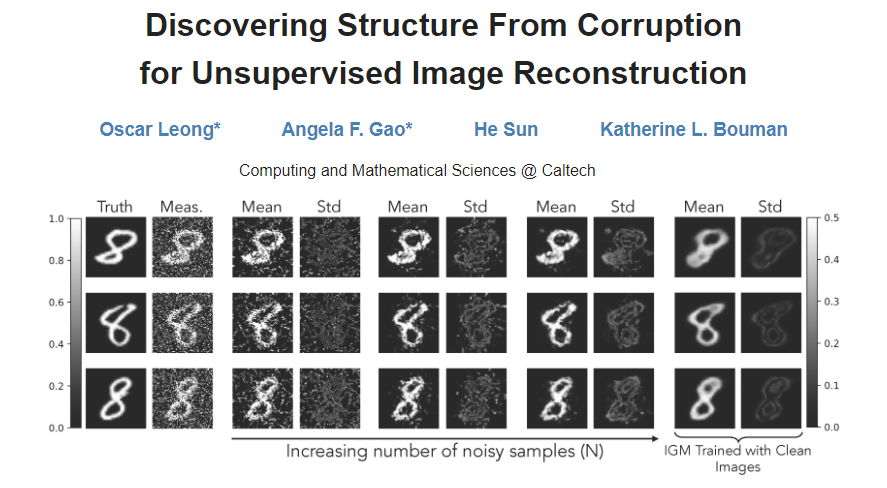

http://imaging.cms.caltech.edu/igm/

In context of Image reconstruction, The MNIST dataset was used extensively by Leong et al. in their study titled "Discovering Structure From Corruption for Unsupervised Image Reconstruction" for solving toy problems and testing their method. Post-successful demonstration of their method on the MNIST dataset, they achieved success on the challenging inverse problem of black hole video reconstruction

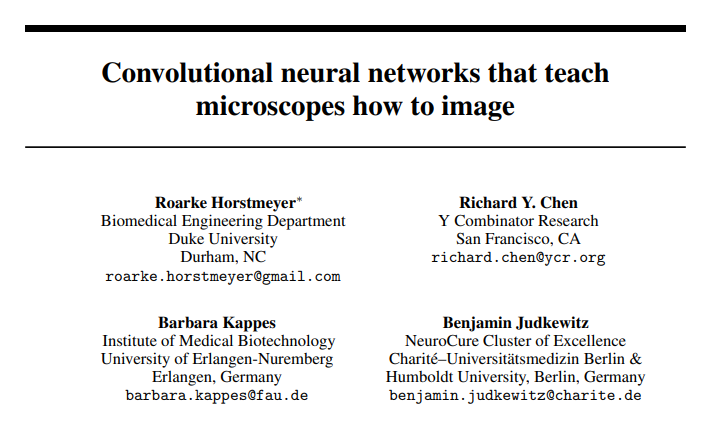

https://arxiv.org/abs/1709.07223

The MNIST dataset was used by Horstmeyer et al. in their study titled "Convolutional neural networks that teach microscopes how to image" to develop a CNN that optimized the "optics"

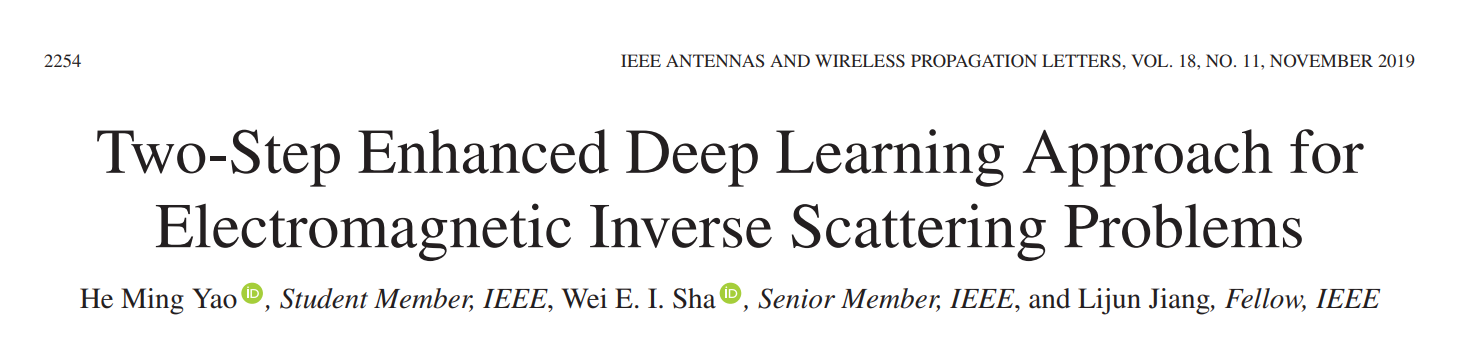

https://ieeexplore.ieee.org/abstract/document/8747485

In context of applying Neural Networks specifically to scattering, the MNIST dataset was used by Yao et al. in their study titled "Two-Step Enhanced Deep Learning Approach for Electromagnetic Inverse Scattering Problems" to verify the effectiveness and accuracy of their approach. In this work, we take a synergistic approach

## Scattering model approaches

### Options

1. First approach: Representing the "grid cells" in our 2D sample as "Mie scattering spheres"
2. Second approach: Applying the "Green's Function" method from Born and Wolf's "optics bible" and Laura's paper

### Analyzing Options

Firstly, it is worth noting that so far we were using the term "pixels" to refer to "pixels" in the output as well as the "grid cells" in the input. There is a distinction here. The output image is divided into "squares" called "pixels". The input is modeled with a suitable spatially-varying "optical properties field" and is continuous, in theory. The "discrete representation" of the input involves assigning values to "squares" that make up the input domain and these squares are called "grid cells". Ideally, these grid cells should be as small as possible leading to a "fine grid" and they do not need to be of the "same size" as the pixels

First Option Analysis:
1. This approach is not based on "first principles" as the following hierarchy of description exists:
    1. Light is incident on a "sample" that is represented as a "grid"
    2. The "grid" has to be mapped to a "discrete array of Mie scattering spheres"
    3. Scattering of Light from the array takes place
2. This hierarchical approach raises several questions about the "physicality" of the approach like:
    1. Why not directly model the scattering process that occurs from the "grid" using "first-principles"?
    2. Why is "Mie scattering" the suitable theory to use here?
    3. Why are "Spheres" the suitable choice of "scattering geometry" to be used here?
    4. What parameters are required to "generate the map" from a "grid" to "Mie scattering spheres"?
    5. How will the map from a "grid" to "Mie scattering spheres" be generated?
    6. What is the "optimal" array resolution required for this approach to work?
    7. Are there credible sources and substantial literature exploring approaches along similar lines?
3. I could not find "relevant literature" on this approach and it is always good practice to ground our work in the literature and back it up with credible sources

Second Option Analysis:
1. This approach is based on "first principles" as it directly models the scattering of the incident light from the sample "grid"
2. This approach is backed up with "solid" sources from the literature:
    1. Born and Wolf's "Principles of Optics" which is considered as the "Bible of Optics"
    2. Laura Waller's work
3. We might be able to represent the "scattering" using a "convolution Layer" where the "kernel" is the "Green's function" and this will not only add a "layer of novelty" (pun fully intended) but also lead to "seamless integration" of the "scattering" in our CNN-based PINN framework
4. The grid resolution may not become a "primary issue" as the focus will shift to the above-mentioned aspects

### Final decision

Go with the second approach

## Scattering model - splitting it up...

### Motivation

1. We will demonstrate that we can "split" the Intensity into a "scattering amplitude factor" and a "polarizaton factor"
2. This splitting will ensure a "seamless integration" of the new ideas into our existing framework
3. Thus, we can split our implementation into two parts:
    1. Scattering Layer
    2. Cross-polarization Layer
4. For now, we will focus on the "Scattering Layer"

### Calculations

$$ \vec{E}(x, y, z) = U(x, y, z) \odot \hat{n}(x, y, z) $$

$$ \vec{E}(x, y, z) \text{ is the Electric Field} $$

$$ \vec{U}(x, y, z) \text{ is a scalar-valued Complex Field} $$

$$ \odot \text{ is the element-wise multiplication operator} $$

$$ \hat{n}(x, y, z) \text{ is a vector-valued Real Field containing unit vectors} $$

$$ \\ $$

$$ \vec{E}_{i}(x, y, z) = U_{i}(x, y, z) \odot \hat{n}_{i} $$

$$ \vec{E}_{i}(x, y, z) \text{ is the incident Electric Field} $$

$$ \vec{U}_{i}(x, y, z) \text{ is a scalar-valued Complex Field representing the incident "magnitude"} $$

$$ \hat{n}_{i} \text{ is a constant Real unit-vector representing the incident "polarization"} $$

$$ \\ $$

$$ \vec{E}_{s}(x, y, z) = U_{s}(x, y, z) \odot \hat{n}_{s}(x, y, z) $$

$$ \vec{E}_{s}(x, y, z) \text{ is the scattered Electric Field} $$

$$ \vec{U}_{s}(x, y, z) \text{ is a scalar-valued Complex Field representing the scattered "magnitude"} $$

$$ \hat{n}_{s}(x, y, z) \text{ is a unit-vector-valued Real Field representing the scattered "polarization"} $$

$$ \\ $$

$$ \text{The total Electric Field is given by:} $$

$$ \vec{E}_{t}(x, y, z) = \vec{E}_{i}(x, y, z) + \vec{E}_{s}(x, y, z)  $$

$$ = U_{i}(x, y, z) \odot \hat{n}_{i} + U_{s}(x, y, z) \odot \hat{n}_{s}(x, y, z)  $$

$$ \\ $$

$$ \text{Consider the action of a real PSF on } \vec{E}_{t}(x, y, z) $$

$$ \vec{E}_{t}(x, y, z) \star \text{PSF} = \vec{E}_{i}(x, y, z) \star \text{PSF} + \vec{E}_{s}(x, y, z) \star \text{PSF}  $$

$$ = (U_{i}(x, y, z) \odot \hat{n}_{i}) \star \text{PSF} + (U_{s}(x, y, z) \odot \hat{n}_{s}(x, y, z)) \star \text{PSF}$$

$$ = (U_{i}(x, y, z) \star \text{PSF}) \odot \hat{n}_{i} + (U_{s}(x, y, z) \star \text{PSF}) \odot \hat{n}_{s}(x, y, z) $$

$$ \\ $$

$$ \text{Now, consider the projection on a "cross-polarizer" } \hat{n}_{cp} $$

$$ (\vec{E}_{t}(x, y, z) \star \text{PSF}) \cdot \hat{n}_{cp} = (U_{i}(x, y, z) \star \text{PSF}) \odot (\hat{n}_{i} \cdot \hat{n}_{cp}) + (U_{s}(x, y, z) \star \text{PSF}) \odot (\hat{n}_{s}(x, y, z) \cdot \hat{n}_{cp})$$

$$ = (U_{s}(x, y, z) \star \text{PSF}) \odot (\hat{n}_{s}(x, y, z) \cdot \hat{n}_{cp})$$

$$ \\ $$

$$ \text{The Intensity at the camera at a point } (x, y, z) \text{ is given by:} $$

$$ I(x, y, z) = {\lvert \lvert (U_{s}(x, y, z) \star \text{PSF}) \times (\hat{n}_{s}(x, y, z) \cdot \hat{n}_{cp}) \rvert \rvert}^2 $$

$$ = {\lvert \lvert U_{s}(x, y, z) \star \text{PSF} \rvert \rvert}^2 \times {\lvert \lvert \hat{n}_{s}(x, y, z) \cdot \hat{n}_{cp} \rvert \rvert}^2 $$

$$ = \text{scattering amplitude factor} \times \text{polarization factor} $$

## Scattering model inspirations

### Born and Wolf

#### Source

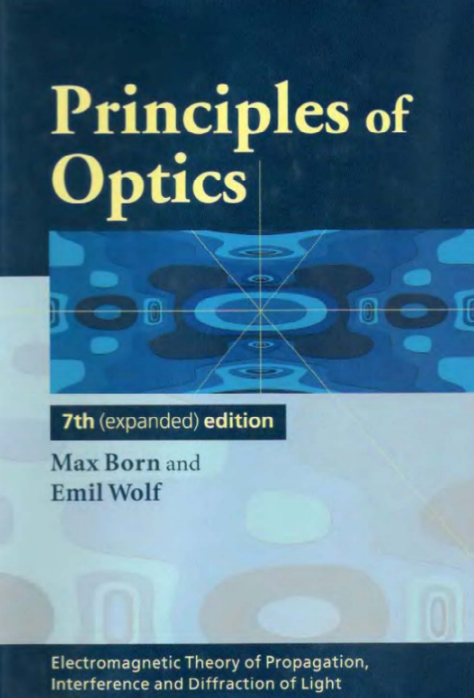

#### ChatGPT fun

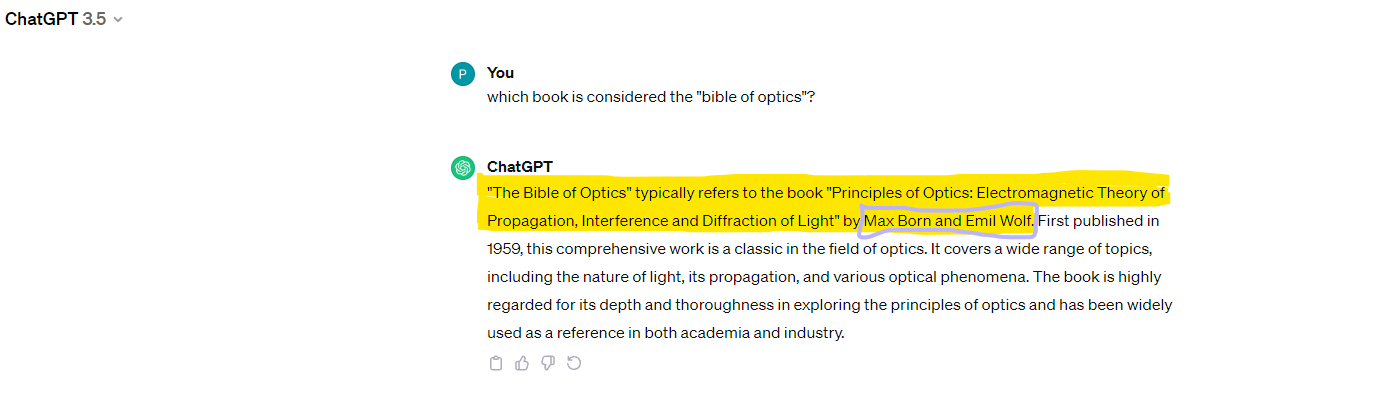

### Laura Waller's work

#### Source

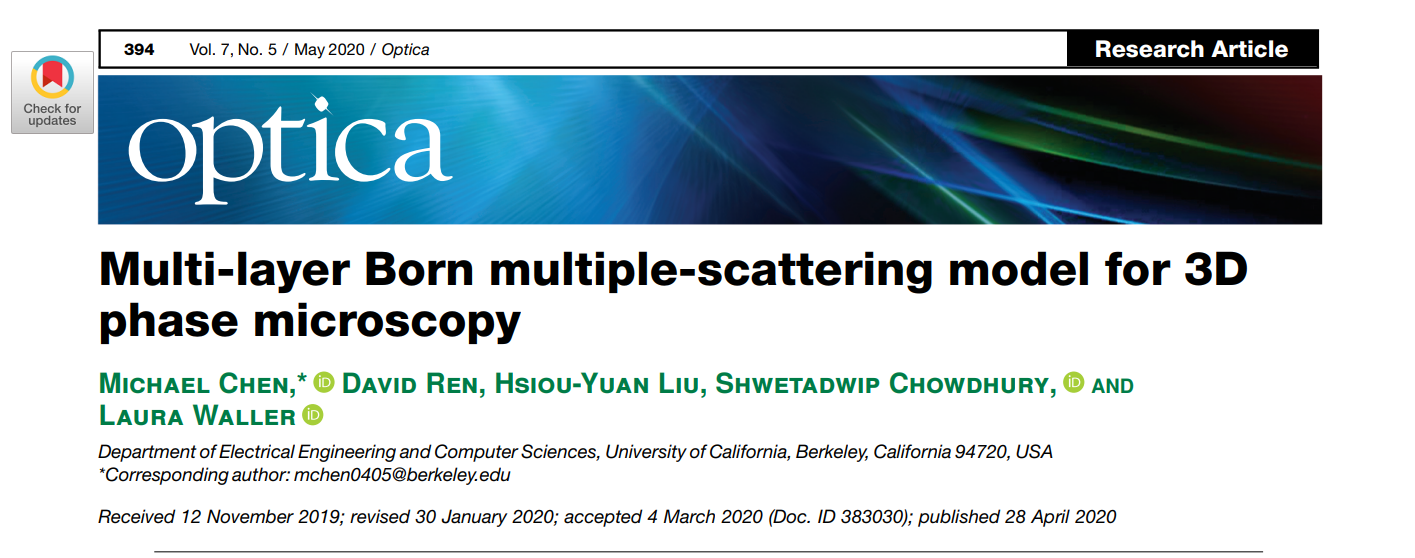

#### Link

https://opg.optica.org/optica/fulltext.cfm?uri=optica-7-5-394&id=431219

## Scattering setup and diagram

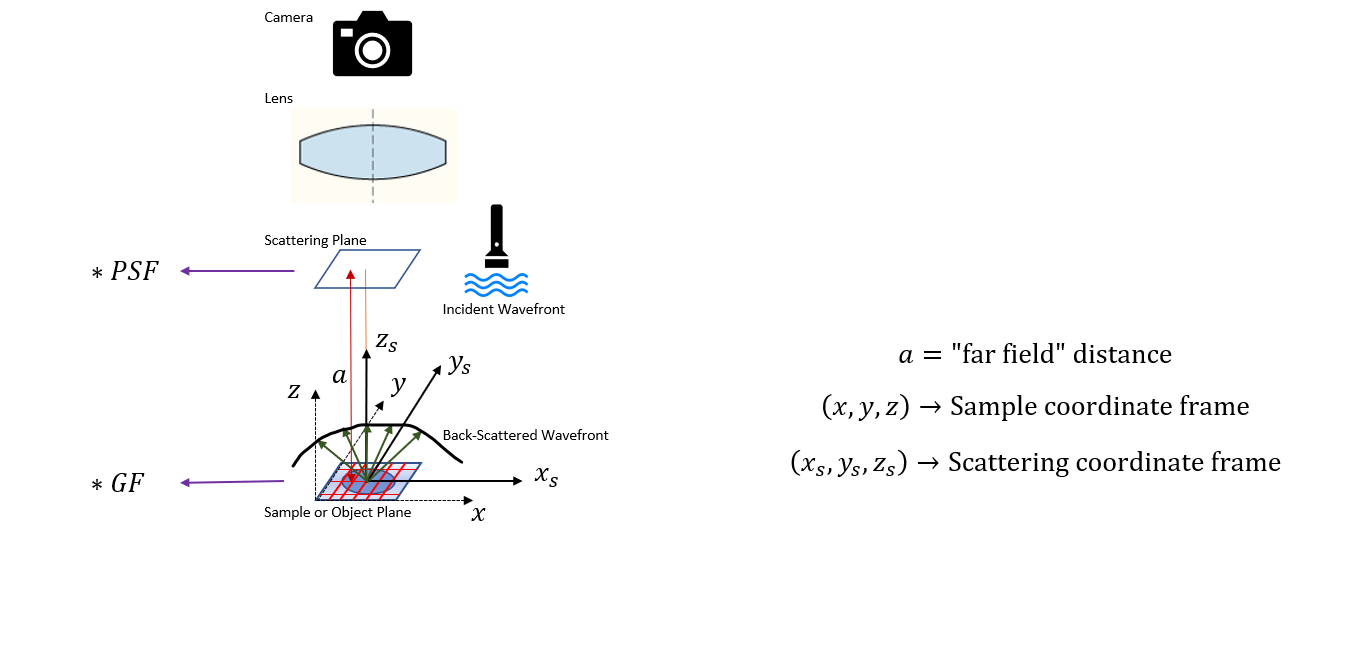

## Scattering assumptions (based on Born and Wolf)

1. The response of the medium to the incident wave is linear and can be described by macroscopic parameters such as the dielectric constant or, equivalently, by the refractive index or dielectric susceptibility
2. "Static scattering" - The response is time-independent
3. The incident light is unit-strength, monochromatic, coherent and a linearly-polarized plane wave
4. The scatterer is finite, isotropic, non-magnetic and source-free
5. The refractive-index "varies slowly" in space and is effectively constant over distances of the order of the wavelength
6. The scattering sample is thin and the "First-order Born approximation" holds
7. The "far-field" approximation is valid for our system
8. The scattered wave is an outgoing "spherical" wave

## Scattering theory

$$ \text{The Green's function is as follows:} $$

$$ G(x, y, z) = \frac{-\exp{(ik{n_b}\sqrt{x^2 + y^2 + z^2})}}{4{\pi}\sqrt{x^2 + y^2 + z^2}} $$

$$ \text{This is the "outgoing free-space Green's function of the Helmholtz operator"} $$

$$ \\ $$

$$ \text{Since the medium surrounding our sample is air, we get:} $$

$$ n_b = 1 $$

$$ \implies G(x, y, z) = \frac{-\exp{(ik\sqrt{x^2 + y^2 + z^2})}}{4{\pi}\sqrt{x^2 + y^2 + z^2}} $$

$$ \\ $$

$$ \text{The scattering equation is given below:} $$

$$ U_{s}(x, y, z) = \iiint G(x-x', y-y', z-z') \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ \\ $$

$$ \text{Note that:} $$

$$ U_{s}(x, y, z) \text{ is the scalar-valued complex field representing the magnitude of the "radially" scattered wave} $$

$$ U_{i}(x, y, z) \text{ is the scalar-valued complex field representing the magnitude of the incident "plane" wave} $$

$$ V(x, y, z) \text{ is the scalar-valued complex field representing the Scattering Potential} $$

$$ \\ $$

$$ U_{s}(x, y, z) = \iiint G(x-x', y-y', z-z') \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = \iiint \frac{-\exp{(ik\sqrt{(x-x')^2 + (y-y')^2 + (z-z')^2})}}{4{\pi}\sqrt{(x-x')^2 + (y-y')^2 + (z-z')^2}} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = \iiint \frac{-\exp{(ik\sqrt{(x-x')^2 + (y-y')^2 + a^2})}}{4{\pi}\sqrt{(x-x')^2 + (y-y')^2 + a^2}} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ \text{Where "} a \text{" is the "far-field" distance} $$

$$ \\ $$

$$ \text{Let us analyze the argument to the Green's function below:} $$

$$ \sqrt{(x-x')^2 + (y-y')^2 + a^2} $$

$$ = \sqrt{a^2(\frac{(x-x')^2}{a^2} + \frac{(y-y')^2}{a^2} + 1)}$$

$$ = a \sqrt{(1 + \frac{(x-x')^2 + (y-y')^2}{a^2})}$$

$$ \approx a (1 + \frac{(x-x')^2 + (y-y')^2}{2a^2}) $$

$$ = a + \frac{(x-x')^2 + (y-y')^2}{2a} $$

$$ = a + \frac{(\Delta{r})^2}{2a} $$

$$ = a + b $$

$$ \\ $$

$$ \text{If } a \gg b \text{:}$$

$$ a + b \approx a $$

$$ \exp{ik(a + b)} \not\approx \exp{ika} $$

$$ \\ $$

$$ \implies U_{s}(x, y, z) = \iiint \frac{-\exp{(ik(a+b))}}{4{\pi}(a+b)} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ \approx \iiint \frac{-\exp{(ik(a+b))}}{4{\pi}a} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = -\frac{1}{4{\pi}a} \iiint \exp{(ik(a+b))} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = -\frac{\exp{(ika)}}{4{\pi}a} \iiint \exp{(ikb)} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = -\frac{\exp{(ika)}}{4{\pi}a} \iiint \exp{(ik\frac{(\Delta{r})^2}{2a})} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = -\frac{\exp{(ika)}}{4{\pi}a} \iiint \exp{(i \sigma (\Delta{r})^2)} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ = -\frac{\exp{(ika)}}{4{\pi}a} \iiint \exp{(i \sigma ((x-x')^2 + (y-y')^2))} \times U_{i}(x', y', z') \times V(x', y', z') dx' dy' dz'$$

$$ \\ $$

$$ \text{For a 2D sample, we get:} $$

$$ U_{s}(x, y, z) \approx -\frac{\exp{(ika)}}{4{\pi}a} \iint \exp{(i \sigma ((x-x')^2 + (y-y')^2))} \times U_{i}(x', y') \times V(x', y') dx' dy'$$

$$ \\ $$

$$ \text{Define the following:} $$

$$ G_{\text{eff}}(x, y) = \exp{(i \sigma (x^2 + y^2))} = e^{(i \sigma (x^2 + y^2))}$$

$$ \eta_{\text{eff}}(x', y') = U_{i}(x', y') \times V(x', y') $$

$$ \\ $$

$$ \implies U_{s}(x, y, z) \approx -\frac{\exp{(ika)}}{4{\pi}a} \iint G_{\text{eff}}(x-x', y-y') \times \eta_{\text{eff}}(x', y') dx' dy'$$

$$ \\ $$

$$ \text{Ignoring the constant "pre-factor", we get:} $$

$$ \implies U_{s}(x, y, z) \approx \iint G_{\text{eff}}(x-x', y-y') \times \eta_{\text{eff}}(x', y') dx' dy'$$

$$ = G_{\text{eff}}(x, y) \star \eta_{\text{eff}}(x', y') $$

$$ \\ $$

$$ \text{Therefore, we get:} $$

$$ \implies U_{s}(x, y, z) \approx G_{\text{eff}}(x, y) \star \eta_{\text{eff}}(x', y') $$

$$ \\ $$

$$ \text{Note that } (x, y, z) \text{ are the cartesian coordinates of points in the "2D scattering plane"}$$

$$\text{Since this plane is parallel to our "sample plane" at a fixed "far-field" distance,}$$

$$\text{We can drop the } z \text{ coordinate to obtain the final expression} $$

$$ \\ $$

$$ \text{Final expression:} $$

$$ U_{s}(x, y) \approx G_{\text{eff}}(x, y) \star \eta_{\text{eff}}(x', y') $$

$$ \\ $$

$$ \text{Summary:} $$

$$ U_{s}(x, y) \approx G_{\text{eff}}(x, y) \star \eta_{\text{eff}}(x', y') $$

$$ G_{\text{eff}}(x, y) = \exp{(i \sigma (x^2 + y^2))} = e^{(i \sigma (x^2 + y^2))}$$

$$ \eta_{\text{eff}}(x', y') = U_{i}(x', y') \odot V(x', y') $$

$$ \star \text{ denotes "convolution"} $$

$$ \odot \text{ denotes "element-wise multiplication"} $$

## Novelty and Literature

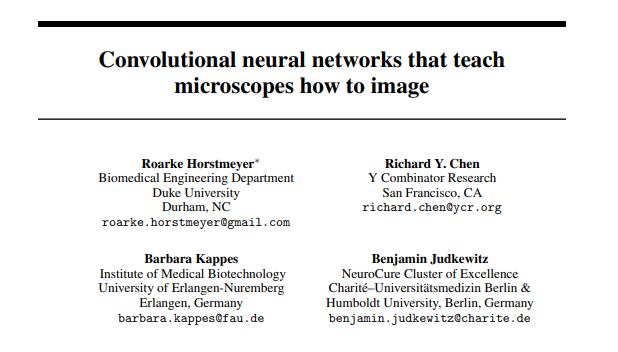

https://arxiv.org/abs/1709.07223

1. Horstmeyer et al. described the "Image formation" process using "Physical CNN Layers". In this work, we extend this idea to scenarios involving thin "scattering" samples viewed in "cross-polarization". We take a step back and consider how light scatters from the sample before interacting with the microscope
2. A "Scattering Layer" based on the mathematical frameworks presented by Laura Waller, Born and Wolf that involves the Green's function formalism and operates under the "First-Born approximation", have been modeled as a "Physical CNN Layer". Then, a "Microscope CNN Layer" adapted from the work by Horstmeyer et al. has been placed. Finally, a "Custom Cross-polarization Layer" has been added at the output end of the forward model
3. Even though the polarizer is actually placed before the camera in a physical setup, placing the "computational polarizer" after the camera does not alter the underlying Physics and reduces computational cost

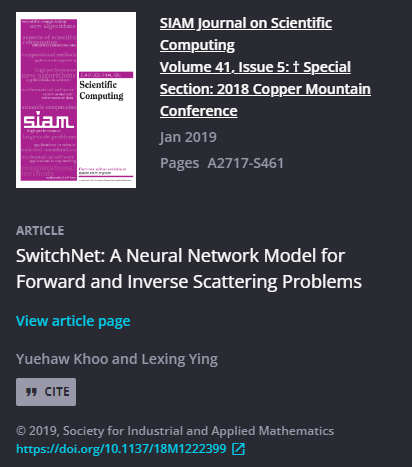

https://web.stanford.edu/~lexing/switchnet.pdf

4. Modeling a "CNN scattering Layer" fits in well with our novel CNN-based architecture representing the unified PINN platform
5. A NN layer can also be viewed as a "Single-layer Network". Thus, we have essentially mapped the scattering equation to a suitable NN architecture. In other words, we have recast the mathematical equation describing scattering in terms of the building blocks of a Convolutional Neural Network. A thorough analysis along similar lines has been conducted by Khoo and Ling in their study titled "SwitchNet: a neural network model for forward and inverse scattering problems" (* revisit this point later - not very sure about this)

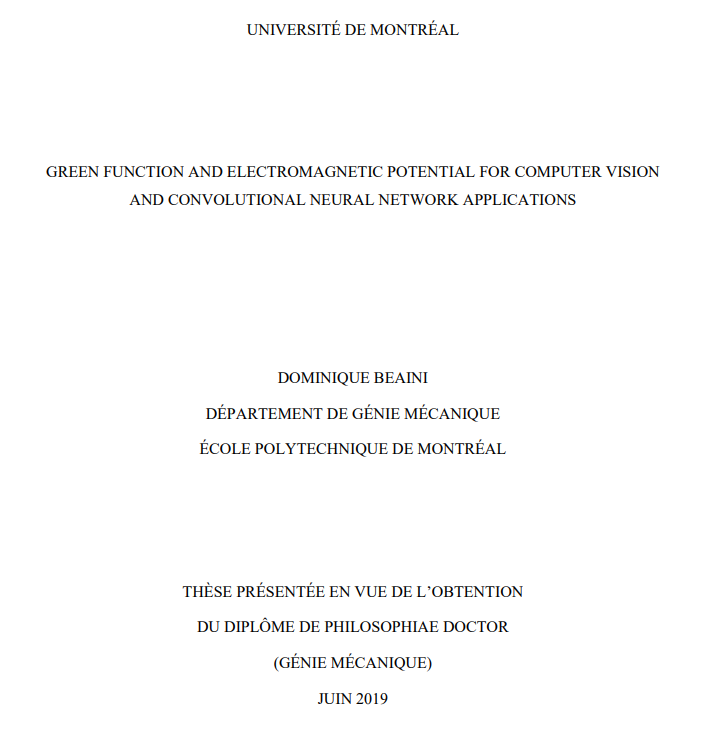

https://www.proquest.com/docview/2507962565?pq-origsite=gscholar&fromopenview=true

6. Here, we have recast scattering as a "Convolutional Layer" based on the Green's function formalism. The study by Beaini titled "Green Function and Electromagnetic Potential for Computer Vision and Convolutional Neural Network Application" by Beaini briefly allude to the lack of literature on using Green's Function inside any type of NN or ML algorithm
7. In summary, this work presents a "novel Scattering Layer" embedded in a CNN-based PINN as part of the forward process that convolves a "Scattering Kernel" based on the system's Green's function with the optical properties field of the sample. We also present a "novel Cross-Polarization Layer" and use "single-view" images

## Analysis of "Effective Reflectance"

$$ \eta_{\text{eff}}(x', y') = U_{i}(x', y') \odot V(x', y') $$

$$ \\ $$

$$ \text{We have discussed the following in earlier presentations:} $$

$$ U_{i}(x', y') = \mathcal{I} $$

$$ \\ $$

$$ \text{Therefore, we get:} $$

$$ \eta_{\text{eff}}(x', y') = V(x', y') $$

$$ \\ $$

$$ \text{Consider the Scattering Potential:} $$

$$ V(x, y, z) = k^{2}({n_b}^{2} - n^{2}(x, y, z)) $$

$$ \implies V(x', y') = k^{2}(1 - n^{2}(x', y')) $$

$$ \\ $$

$$ \text{Define the "ground truth" optical properties map:} $$

$$ n(x', y') = \sqrt{1 - \frac{\alpha g(x', y')}{k^{2}}} $$

$$ \alpha = 0.01 $$

$$ g(x,y) \text{ is the normalized pixel intensity of the MNIST sample} $$

$$ \alpha \text{ is a proportionality constant chosen arbitrarily} $$

$$ \\ $$

$$ \text{Compute the Scattering Potential from the "ground truth":} $$

$$ n(x', y') = \sqrt{1 - \frac{\alpha g(x', y')}{k^{2}}} $$

$$ \implies n^{2}(x', y') = 1 - \frac{\alpha g(x', y')}{k^{2}} $$

$$ \implies 1 - n^{2}(x', y') = \frac{\alpha g(x', y')}{k^{2}} $$

$$ \implies k^{2}(1 - n^{2}(x', y')) = \alpha g(x', y') $$

$$ \implies V(x', y') = \alpha g(x', y') $$

$$ \\ $$

$$ \text{Compute the "Effective Reflectance" from Scattering Potential:} $$

$$ \eta_{\text{eff}}(x', y') = V(x', y') $$

$$ \implies \eta_{\text{eff}}(x', y') = \alpha g(x', y') $$

$$ \\ $$

$$ \text{Thus, we obtain:} $$

$$ \eta_{\text{eff}}(x', y') = \alpha g(x', y') $$

$$ \\ $$

$$ \text{Recall from earlier presentations:} $$

$$ \eta(x', y') = \alpha g(x', y') $$

$$ \implies \eta_{\text{eff}}(x', y') = \eta(x', y')$$

$$ \\ $$

$$ \text{Summary:} $$

$$ \eta_{\text{eff}}(x', y') = \eta(x', y') = \alpha g(x', y') $$

$$ \alpha = 0.01 $$

## Conclusions for "Effective Reflectance"

1. We can use the "reflectance" from the "non-scattering" framework as the "effective reflectance for the new "scattering" framework
2. We have defined a "ground truth" refractive index using a "custom rule" as we have the freedom to do so here in a "simulation-based" study

## Choice of "sigma" can be arbitrary

$$ \sigma = \frac{k}{2a} $$

$$ = \frac{2 \pi}{\lambda \times 2a} $$

$$ = \frac{\pi}{\lambda \times a} $$

$$ \\ $$

$$ \implies \sigma = \frac{\pi}{\lambda a} $$

$$ \text{Fixing } \sigma \text{ fixes the product between } a \text{ and } \lambda $$

$$ \text{Thus, } a \text{ and } \lambda \text{ are "free" parameters} $$

$$ \text{These "free" parameters can be chosen to maintain "Physicality"} $$

$$ \\ $$

$$ \text{Therefore, we set:} $$

$$ \sigma = 1 $$

## Points to note

1. The functional form of the Green's function is independent of the origin of coordinate of the frames corresponding to the "scattering plane" and "reflectance field", the relative translation between them is redundant while studying the complex-valued scalar field that represents the magnitude of the Electric field ("scattering amplitude field"). Coordinate frame for image is translated from the "scattering frame" as the "image frame" has its origin at the corner whereas the "scattering frame" has its origin at the center. It is worth noting that this won't matter for the convolution part as this part is independent of the location of the respective origins. However, this might matter for the "Cross-polarization Layer" and we will need to account for that when we get there
2. The expressions we derived assumed that the "scattering plane" was "parallel" to the "sample plane" which can occur in both, "transmission" and "reflection". The final result we obtained was independent of the location of the scattering plane (in front of sample plane or behind sample plane), meaning that as of now, we cannot "distinguish" between "transmission" and "reflection", based on the complex-valued scalar field that represents the amplitude or magnitude of the scattered field. This is consistent with the assumption of an "isotropic scatterer". Future work should consider incorporation of "anisotropy" in the scattering model and analyze the effect of the "reflection"
3. The "slowly-varying" refractive index condition is redundant for our "theoretical" scattering kernel as we demonstrate above via the analysis detailing the choice of the "sigma" parameter. Future work should consider values of "sigma" that are consistent with the experimental setup of the optical system being analyzed
4. We dropped the constant "pre-factor" that appeared in the scattering amplitude. This pre-factor was a product of a constant "phase-factor" and a constant real scalar. The constant phase-factor will tag along till the Intensity computations and will then collapse to unity. The constant real scalar is redundant as we are interested in "reflectance contrast". Regardless, the effect of this constant can be corrected during "post-processing" with a simple multiplication
5. We will be "normalizing" the "scattering kernels" for the Machine Learning (ML) part as this is of paramount importance in ML. This "normalization factor" can again be handled using the aforementioned techniques

## "Theoretical" Scattering kernel (Real part)

In [17]:
sigma = 1.0
SKR_size = 15 # SKR = Scattering Kernel Real
SKR = torch.zeros(SKR_size, SKR_size)
SKR_center = SKR_size // 2
for x in range(SKR_size):
    for y in range(SKR_size):
        SKR[x, y] = torch.cos(sigma * torch.tensor((x - SKR_center) ** 2 + (y - SKR_center) ** 2))     

SKR /= SKR.sum()

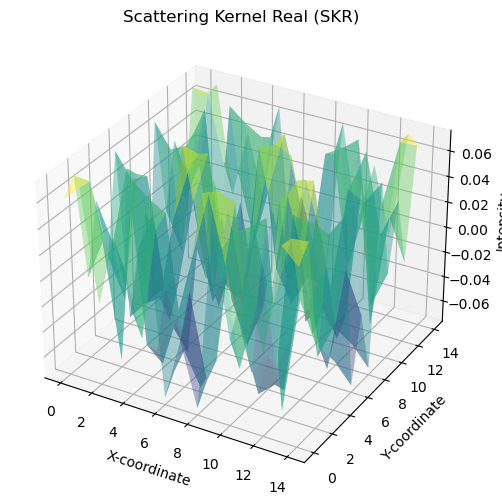

In [18]:
SKR_plot = SKR.numpy()

x = torch.arange(SKR_size)
y = torch.arange(SKR_size)
x, y = torch.meshgrid(x, y)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, SKR_plot, cmap='viridis', alpha=0.4)

ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Intensity')
ax.set_title('Scattering Kernel Real (SKR)')

plt.show()

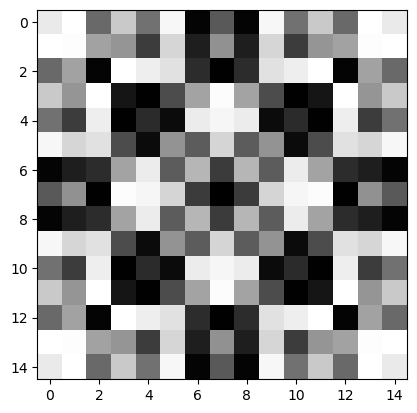

In [19]:
plt.figure()
plt.imshow(SKR_plot, cmap='gray')

## "Theoretical" Scattering kernel (Imaginary part)

In [20]:
SKI_size = 15 # SKR = Scattering Kernel Imaginary
SKI = torch.zeros(SKI_size, SKI_size)
SKI_center = SKI_size // 2
for x in range(SKI_size):
    for y in range(SKI_size):
        SKI[x, y] = torch.sin(sigma * torch.tensor((x - SKI_center) ** 2 + (y - SKI_center) ** 2))     

SKI /= SKI.sum()

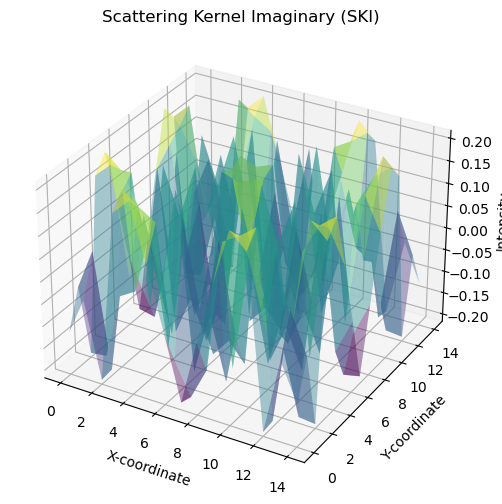

In [21]:
SKI_plot = SKI.numpy()

x = torch.arange(SKI_size)
y = torch.arange(SKI_size)
x, y = torch.meshgrid(x, y)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, SKI_plot, cmap='viridis', alpha=0.4)

ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Intensity')
ax.set_title('Scattering Kernel Imaginary (SKI)')

plt.show()

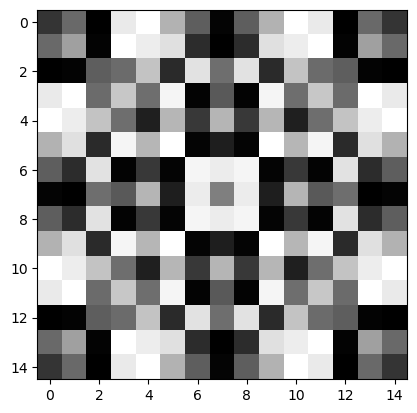

In [22]:
plt.figure()
plt.imshow(SKI_plot, cmap='gray')

## Visualize Scattering kernels

Text(0.5, 1.0, 'Imaginary')

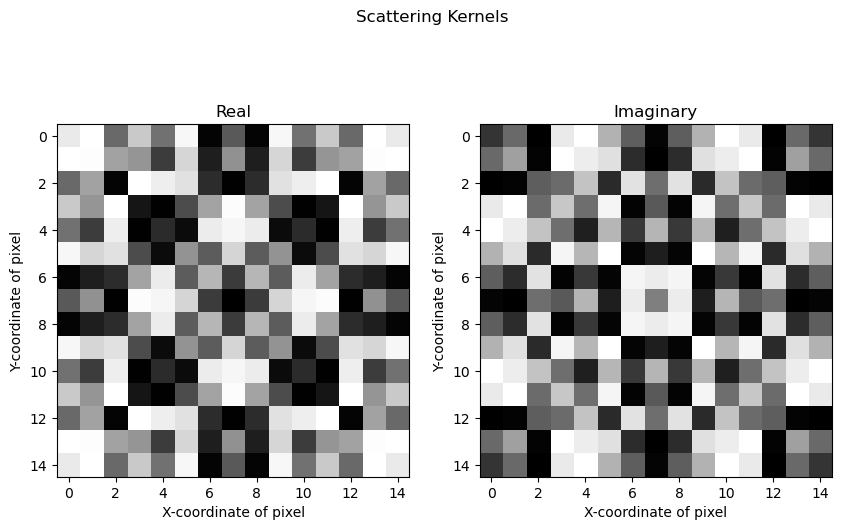

In [23]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Scattering Kernels")

ax_1.imshow(SKR_plot, cmap='gray')
ax_1.set_xlabel('X-coordinate of pixel')
ax_1.set_ylabel('Y-coordinate of pixel')
ax_1.set_title('Real')

ax_2.imshow(SKI_plot, cmap='gray')
ax_2.set_xlabel('X-coordinate of pixel')
ax_2.set_ylabel('Y-coordinate of pixel')
ax_2.set_title('Imaginary')

## Implementing the "complex" scattering kernel

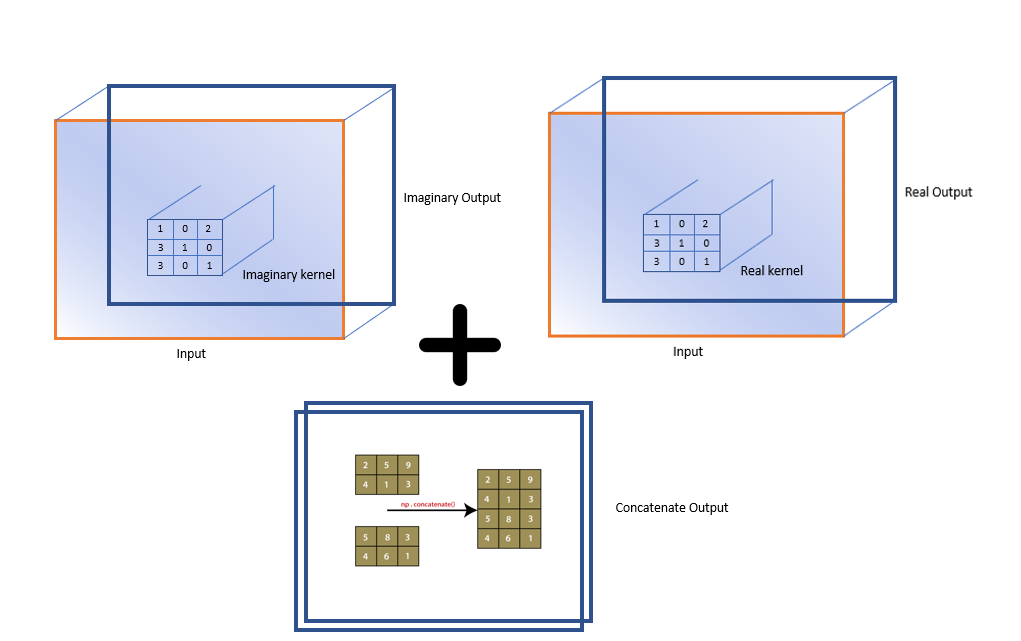

Green's function is complex - so we could have a "complex-valued kernel" with fixed weights - the way we can handle this is as follows:
1. Have a "custom" layer that requires the "real kernel" and "imaginary kernel" for the initialization (__init__ part)
2. The forward pass of the computation layer will independently apply the "real kernel" and "complex kernel" to the "effective reflectance"
3. Finally, the "real output" and "imaginary output" will be concatenated into a "double channel" output, similar to the CoordConv2D Layers
4. Set "requires_grad" to 'False' and check that this is reflected as "non-trainable params" in the "summary" obtained using "torch summary"
5. The input here will be "single channel"

## Limitations of the proposed implementation and CVNNs

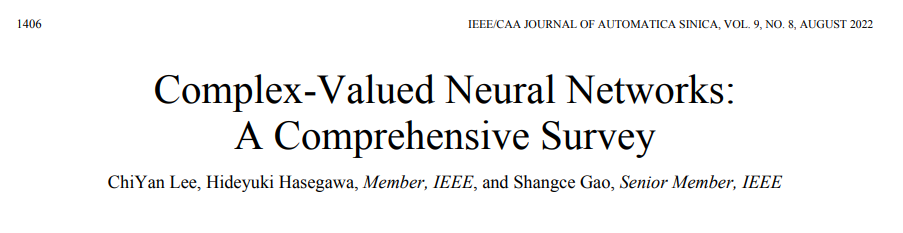

https://ieeexplore.ieee.org/document/9849162

1. Using separate channels for real and imaginary numbers leads to phase distortion and inaccuracy in approximating the output of the neural network as it is updated via real-valued gradients, which are not representative of the true complex gradients
2. On the contrary, "Complex-valued Neural Networks" (CVNNs) with complex-valued weights and real-valued activation functions overcome the phase distortion problem, which is caused by splitting of the complex-valued signal into two real-valued channels
3. In complex-valued signals, the phase component carries critical information and therefore should be considered during training. Fully CVNNs preserve phase information and have better representation than "Real-valued Neural Networks" (RVNNs) in dealing with complex-valued problems
4. Thus, CVNNs are the most compatible model for wave-related information processing as it can directly deal with the phase and amplitude components
5. In addition, the extension of CNNs into the complex domain enables accurate representation of magnitude and phase
6. The aforementioned ideas have been discussed thoroughly in the article by Lee et al. titled "Complex-Valued Neural Networks: A Comprehensive Survey"

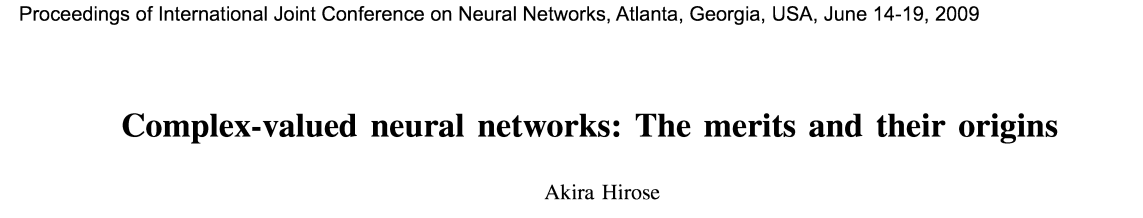

https://ieeexplore.ieee.org/document/5178754

The importance of the "phase-and-amplitude viewpoint" and their synergy with CVNNS has been discussed at length by Hirose in their article titled: "Complex-valued neural networks: The merits and their origins". This viewpoint is of a fundamental importance in dealing with electromagnetic waves such as light

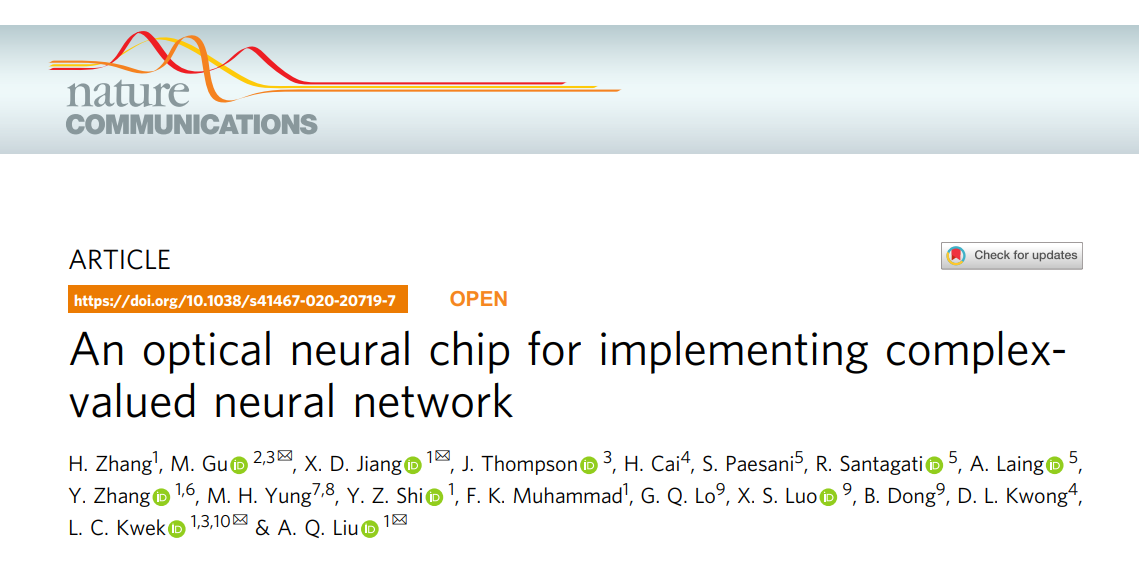

https://www.nature.com/articles/s41467-020-20719-7

1. The study by Zhang et al. titled "An optical neural chip for implementing complex-valued neural network" highlights an optical neural chip that implements truly complex-valued neural networks and demonstrates superior performance in comparison to its real-valued counterpart
2. They also mention that convention digital electronic computing platforms are incapable of executing truly complex-valued representations and operations
3. Not only do they emphasize the versatility of optical computing platforms due to their ability in dealing with phase and magnitude but also bring to notice that the literature has not taken adequate cognizance of CVNNs and as a consequence, they have not been sufficiently explored
4. CVNNs may have the potential to provide "enhance robustness" while solving inverse-problems in optics (at least, wave-based)
5. It is also worth noting that popular deep learning frameworks like PyTorch (cite) are based on RVNNs and currently do not support CVNNs

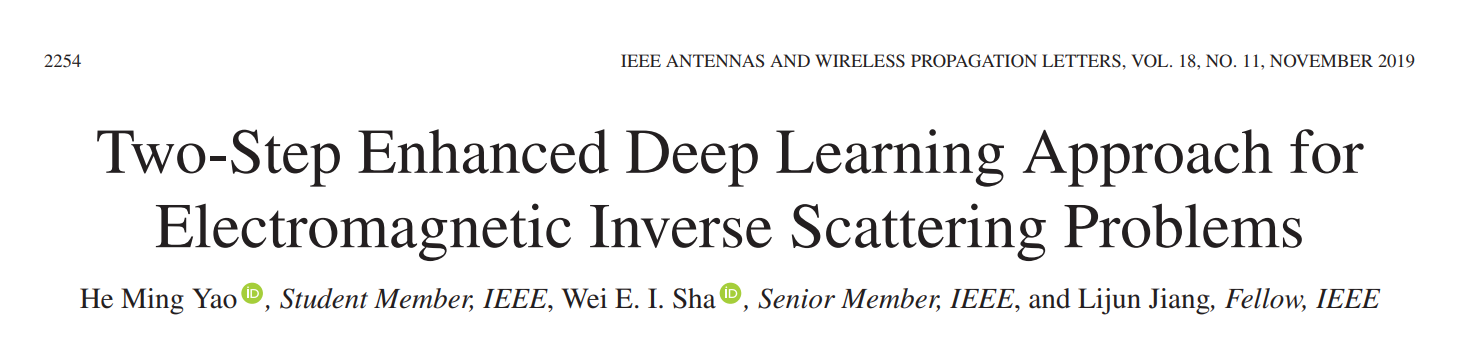

https://ieeexplore.ieee.org/abstract/document/8747485

1. In synergy with our style, Yao et al. have developed a novel framework for solving inverse scattering problems where they also use a CNN-based architecture, the MNIST dataset to demonstrate efficacy of their method and the ADAM optimizer. However, their approach fundamentally differs from our approach in their use of CVNNs
2. Future work could consider the development of scientific computing libraries for implementing CVNNs for optical problems "ab-initio"

## Notes on the "inverse problem" - straight from the "bible"

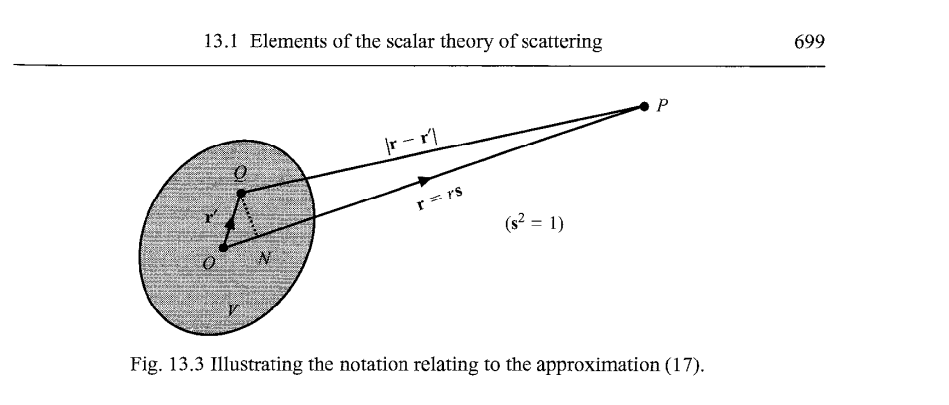

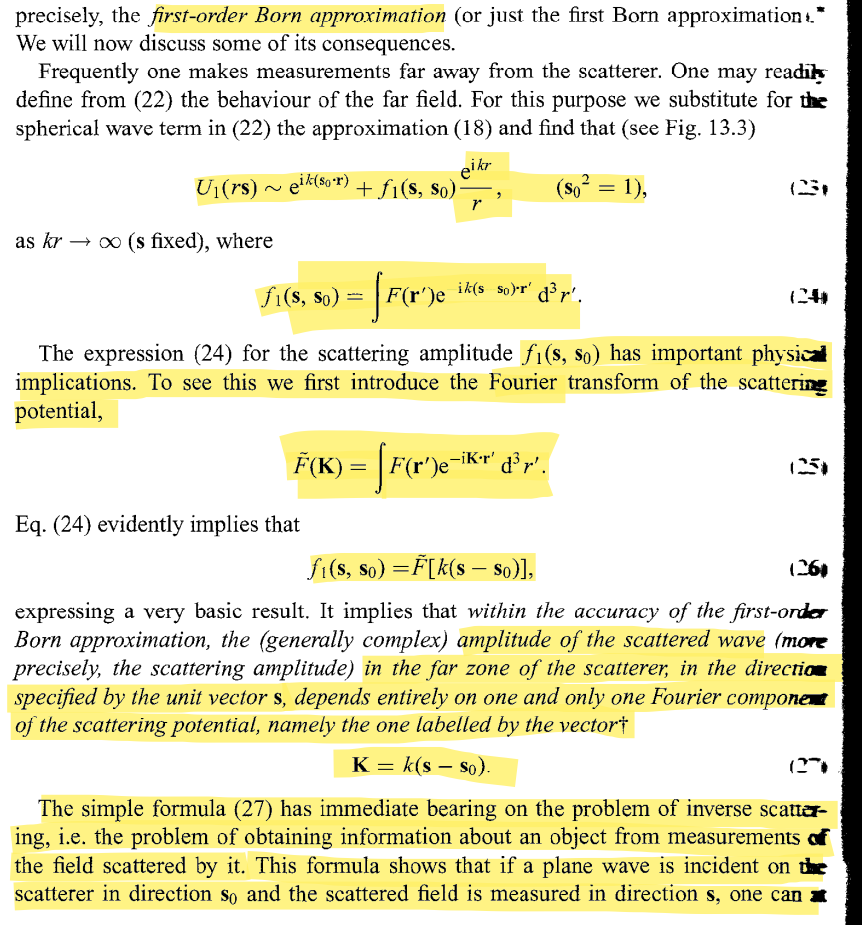

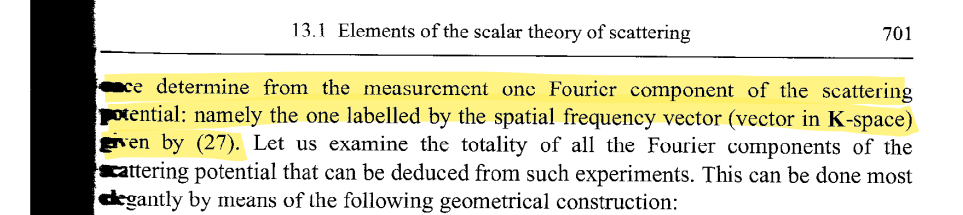

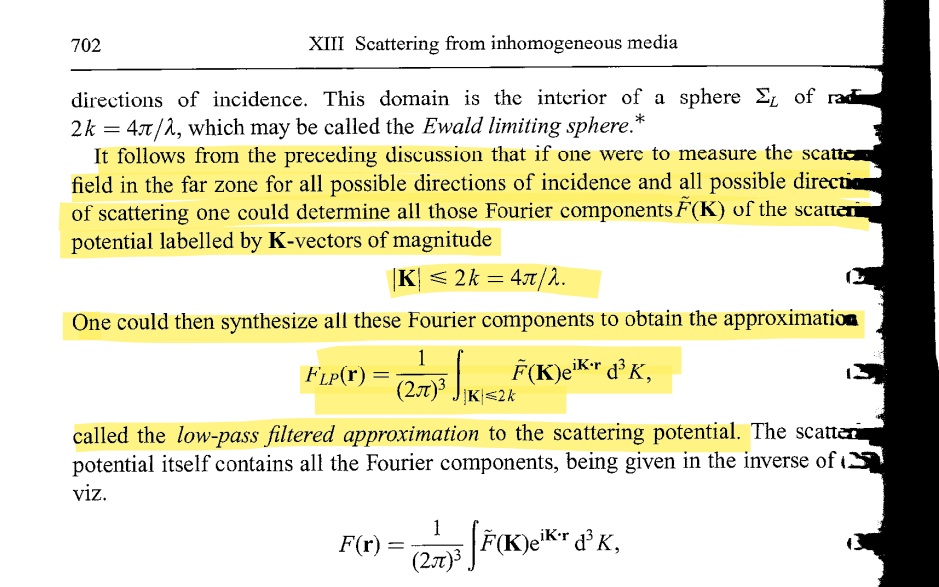

### Summary of the highlights

1. What this means is that an approximation to the "Optical Material Properties" can be obtained using an inverse Fourier Transform if we have measurements in the Fourier Space corresponding to the Fourier variable defined by the difference in the "input illumination direction" and "scattered angle direction" - put simply, we need multiple illumination angles, at the very least...
2. That is why Laura was using multiple angles...

### Implications for our project

1. Multiple angles are required to solve our inverse problem based on the theory proposed by Physics Nobel Laurate Max Born
2. We will start with the "well-posed" inverse problem (multiple angles) and successively iterate our software "step-by-step" to finally tackle the "ill-posed" inverse problem
3. Starting with multiple angles:
    1. Required to validate our software (inverse-solver) - we should be able to solve a well-posed problem in principle so it makes sense to first test on this case
    2. Required to debug our code during development (inverse-solver)
    3. Satisfies the theory proposed by Born
    4. Beauty about simulation is that we can do multiple angles without having to worry about any experimental apparatus
    5. Neural Network platforms that have accurate syntax are hard to debug as they throw no errors - that is why we need a case with a "known or expected" answer - a "test case" - multiple angled illumination
4. We will have to carefully think about the changes that will have to be made to the rest of the code in terms of "complex channels" and tensor shapes when we vary our illumination direction
5. Once we get to the stage of our ultimate goal, "single-view output", we can look at Katie Bouman's paper (below) on tackling "ill-posed inverse problems without priors with image sharing commonality" where she starts with MNIST digits and ends applying her method to the challenging real-world application of black-hole videography

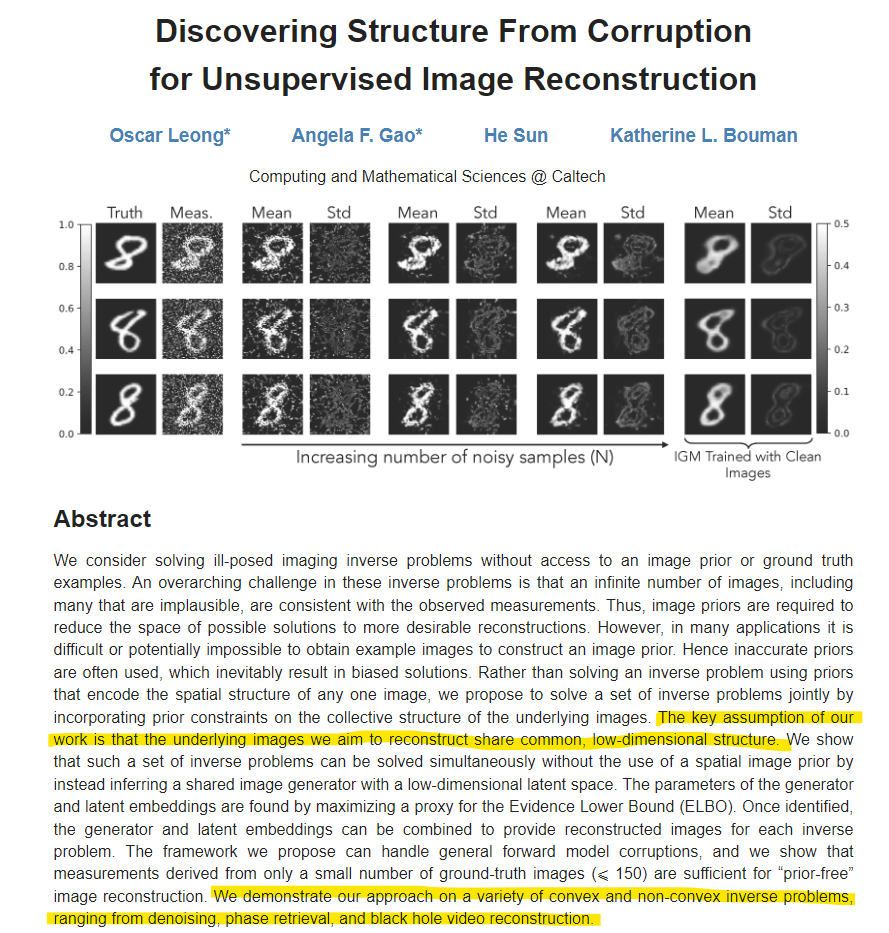

http://imaging.cms.caltech.edu/igm/

### Good starting point for "Inverse Problems" and "Benchmarking"...

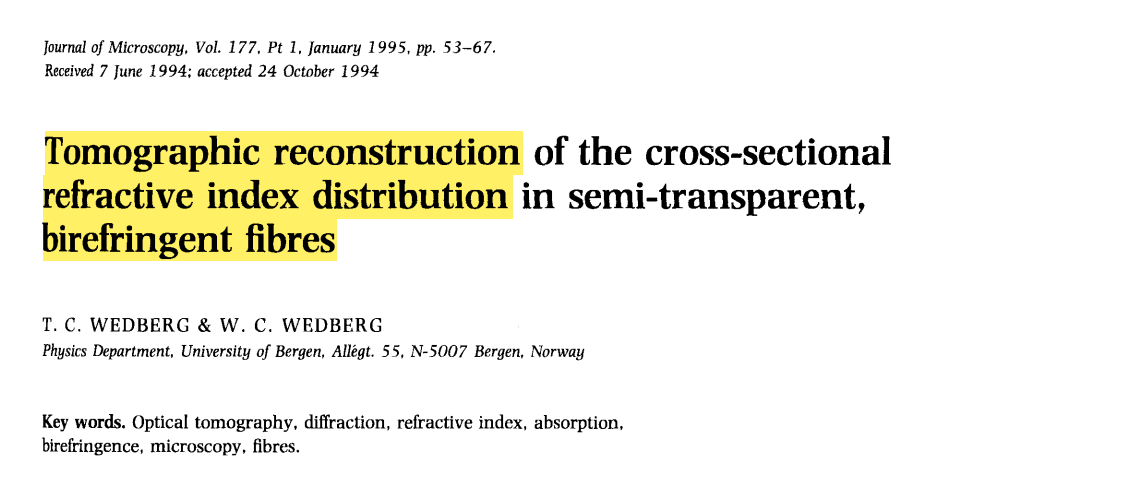

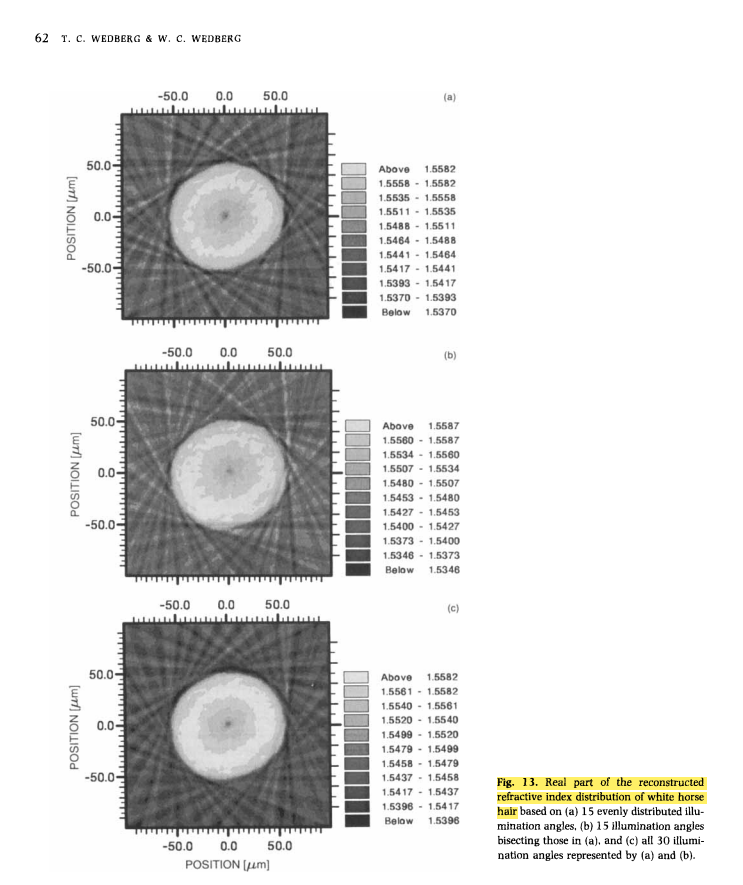

https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1365-2818.1995.tb03533.x

## Modifications to existing PINN architecture

1. We will have to carefully take into account all the changes that will take place in the "shapes" of the various tensors involved in the PINN architecture due to the "complex-ness" entering the picture through the complex kernel and varying illumination angle:
    1. In case of normal illumination and complex kernel - we should hopefully be able to split the complex kernels into "real" and "imaginary" channels and do the same operations on each channel
    2. In case if oblique illumination and complex kernel - we need to think very very carefully for this case:
        1. Firstly, we should go over the entire document and carefully track all the theory and equations to see where changes occur exactly due to the "obliqueness"
        2. Second, we will most likely have a convolution of a complex kernel with a complex input and in this case, we cannot do a simple "real" and "imaginary" channel "split" as common intuition dictates that we will have "interference terms" that we will need to carefully account for using "interference channels" (I still need to work out the exact math)
2. We will also have to think carefully about the tensor shape changes due to the addition of new layers
3. The intensity layer will have to be modified for the "double channel" complex-valued fields. We can do : Intensity = torch.square(field(:, 0, :, :)) + torch.square(field(:, 1, :, :))
4. We will have to add a new "Cross-polarization Layer" at the very end

## Considerations before going to "real collagen images"

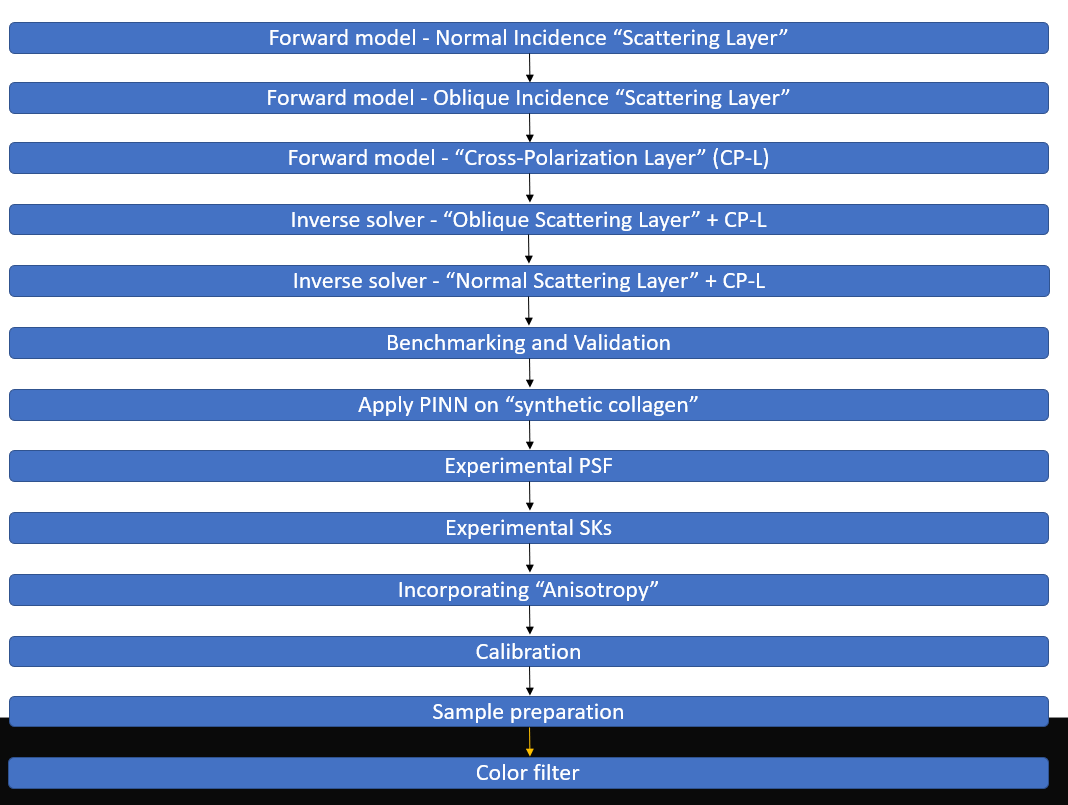

1. Incorporating scattering theory
2. Validation and Benchmarking: Directly applying our framework to real collagen images requires thorough validation and benchmarking against existing methods or ground truth data. Assessing the accuracy and robustness of our framework on datasets with "known ground truth" is crucial for establishing its efficacy in practical scenarios. This means that, in absence of "ground truth" data, we will need to do the "comparison with other standard algorithms" step. Given that we are interested in eventually using collagen-rich tissue, in the short-term, it might make sense to apply our PINN-based framework to "synthetic collagen data" which at least demonstrates the efficacy of our PINN-based framework on a "representative sample" and provides us with "ground-truth" data for "validation". If the PINN-based framework performs well on the "representative synthetic collagen sample", we could make the case for directly applying our PINN-based framework to images of real collagen samples, if we are under time pressure. Ideally, "representative samples or not", we should do the "comparison with other standard methods" step as that is the only real way to "benchmark" our framework in the absence of ground-truth data
3. Applying PINN on "synthetic collagen"
4. PSF: Another point to note that while transitioning to real images, we will have to carefully determine the Point Spread Function (PSF) of our microscope
5. SKs: Just like the PSF, we will also have to carefully determine the "Scattering kernels" that are based on the Green's function
6. Incorporating "Anisotropy": We will need to incorporate anisotropy in our scattering model and then extract information about the reflection mode
7. Calibration: We will also need to experimentally measure the background illumination and apply an appropriate calibration
8. Sample preparation: We will also need to ensure that we have a sample placed on glass slide with black tape underneath or have air underneath, so that the secondary reflections can be removed
9. Color filter: We will need a color filter to be used within our microscope so that we are working in the monochromatic illumination or expand our theory to handle white light

Given this analysis, the steps that "ideally" need to be accomplished before working with "real collagen images" are the following:
1. Incorporation of Scattering Theory in the Forward model
2. Comparison with other standard methods for inverse-problems like:
    1. Standard-filtered backprojection method
    2. Total Variation (TV) regularization
    3. Tikhinov Regularization
    4. Simulation-informed Model-Based Analysis (SIMBA)
3. Applying our PINN-based framework to synthetic data emulating collagen-rich tissue samples
4. Using a realistic PSF compatible with our microscope
5. Using realistic SKs compatible with our sample
6. Incorporate "Anisotropy"
7. Calibration of background illumination
8. Sample preparation to remove secondary reflections
9. Color filter
10. Validation of the "rudimentary" model with well-behaved thin 2D material samples like Air Force Test Target
12. Extend the inverse-solver of our PINN framework to "segment" collagen fibers using CNN Layers
13. Extract "waviness distribution" from the "extended" PINN framework
14. Application of our PINN framework to a "real" sample of collagen-rich tissue
15. Validate a "real" sample of collagen with an "optically annotated" common coordinate system using confocal microscopy
16. Compare results of our extended PINN on "real" collagen with CT-Fire

## MNIST motivation revisited...

Given the considerations before going to "real collagen images", the challenges encountered in developing representative tissue phantoms for advanced optical imaging modalities, the simplicity and accessibility of MNIST digits and the success researchers have achieved with them in terms of testing their methods and demonstrating efficacy in context of problems from the domains of image reconstruction, optical setup optimization and scattering, as well as our success with the MNIST dataset so far, it makes sense to completely focus on using the MNIST dataset for now, then try out "synthetic collagen" and to that end, a "Phased approach" has been proposed below

## Phased approach

### First Paper: PINN + "Simulation"

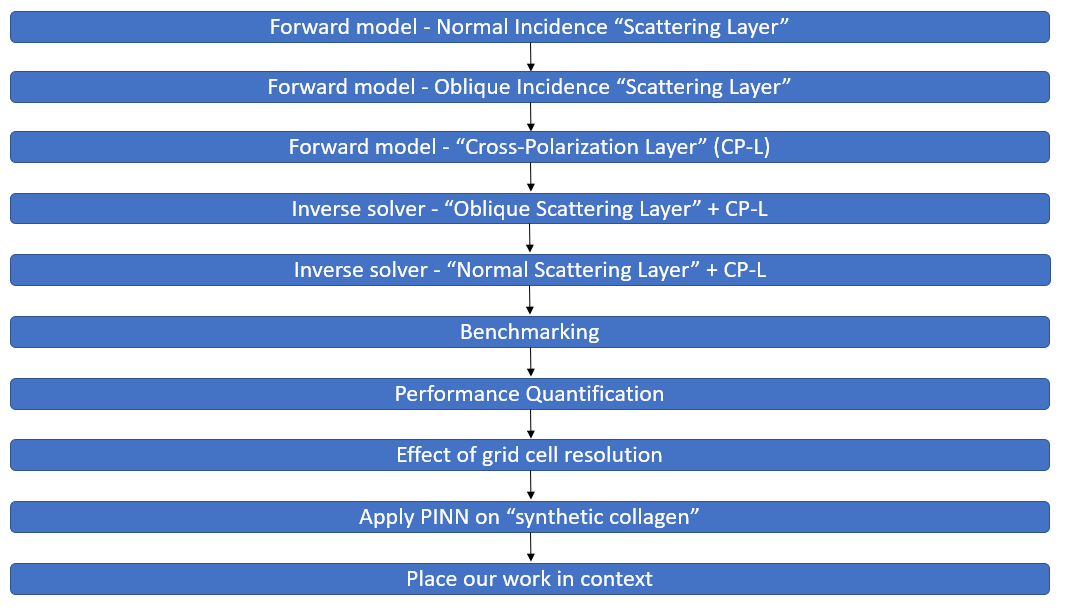

This paper will focus on the "efficacy and impact" of our PINN-based framework in a "broader context"

1. Incorporation of Scattering Theory in the Forward model
2. Comparison with other standard methods for inverse-problems like:
    1. Standard-filtered backprojection method
    2. Total Variation (TV) regularization
    3. Tikhinov Regularization
    4. Simulation-informed Model-Based Analysis (SIMBA)
3. Standard Performance Quantification (We might not need this - use Katie Bouman's paper as template)
4. Report on the effect of "grid cell resolution"
5. Applying our PINN-based framework to synthetic data emulating collagen-rich tissue samples
6. Layout the context for PINNs

### Second Paper: Waviness + "Experiment"

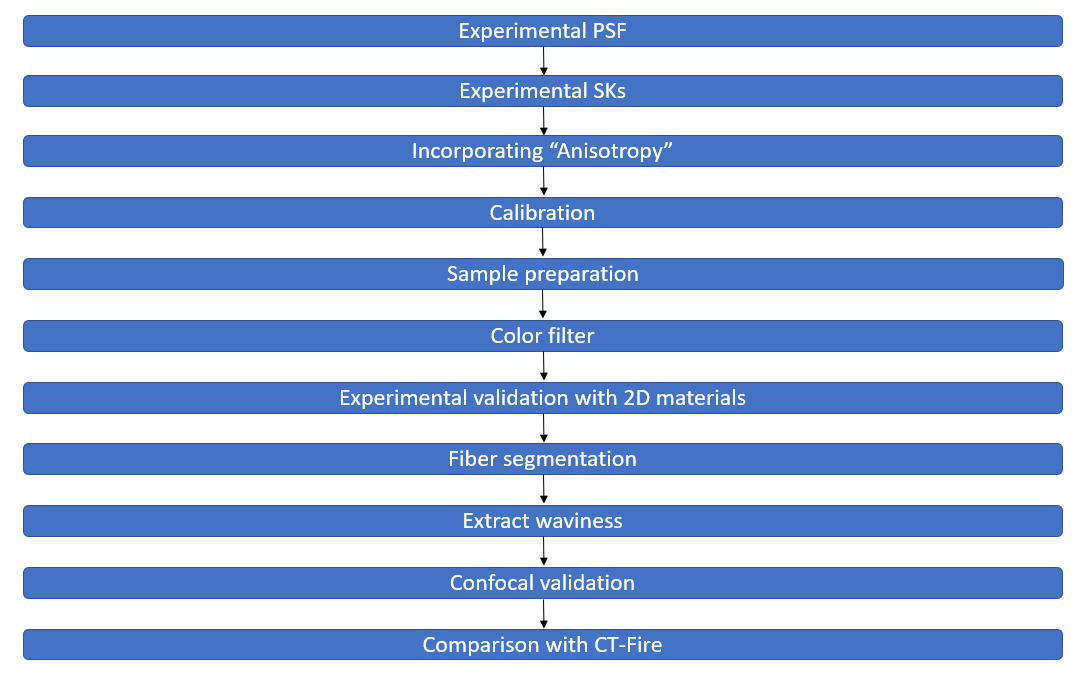

This paper will focus on the "application" of our platform to collagen waviness

1. Using a realistic PSF compatible with our microscope
2. Using realistic SKs compatible with our sample
3. Incorporate "Anisotropy"
4. Calibration of background illumination
5. Sample preparation to remove secondary reflections
6. Color filter
7. Validation of the "rudimentary" model with well-behaved thin 2D material samples like Air Force Test Target
8. Extend the inverse-solver of our PINN framework to "segment" collagen fibers using CNN Layers
9. Extract "waviness distribution" from the "extended" PINN framework
10. Application of our PINN framework to a "real" sample of collagen-rich tissue
11. Validate a "real" sample of collagen with an "optically annotated" common coordinate system using confocal microscopy
12. Compare results of our extended PINN on "real" collagen with CT-Fire

## Next steps

Next steps should be implementation of our "novel scattering layer" based on this document:
1. Normal Illumination
2. Oblique Illumination
3. Cross-Polarization
4. Test forward model after these steps
5. Test inverse solver